In [2]:
import pyopenms
from pyopenms import *

In [1]:
with open("F:/FCI/Senior/1st Semester/Computational Biology Techniches/Project/Raw/Fusion_180220_08.mzML") as f:
    for x in range(1000):
        print(f.readline().strip())

<?xml version="1.0" encoding="utf-8"?>
<indexedmzML xmlns="http://psi.hupo.org/ms/mzml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://psi.hupo.org/ms/mzml http://psidev.info/files/ms/mzML/xsd/mzML1.1.2_idx.xsd">
<mzML xmlns="http://psi.hupo.org/ms/mzml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://psi.hupo.org/ms/mzml http://psidev.info/files/ms/mzML/xsd/mzML1.1.0.xsd" id="Fusion_180220_08" version="1.1.0">
<cvList count="2">
<cv id="MS" fullName="Proteomics Standards Initiative Mass Spectrometry Ontology" version="4.1.56" URI="https://raw.githubusercontent.com/HUPO-PSI/psi-ms-CV/master/psi-ms.obo"/>
<cv id="UO" fullName="Unit Ontology" version="09:04:2014" URI="https://raw.githubusercontent.com/bio-ontology-research-group/unit-ontology/master/unit.obo"/>
</cvList>
<fileDescription>
<fileContent>
<cvParam cvRef="MS" accession="MS:1000579" name="MS1 spectrum" value=""/>
<cvParam cvRef="MS" accession="MS:1000580" name

In [4]:
exp = MSExperiment()

# Load mzML file
MzMLFile().load("F:/FCI/Senior/1st Semester/Computational Biology Techniches/Project/Raw/Fusion_180220_08.mzML", exp)

spectra = exp.getSpectra()

In [37]:
# Get the spectrum number 7 (index number 6)

observed_spectrum = spectra[6]
print(observed_spectrum)

## Proteolytic Digestion with Trypsin 

In [6]:
dig = ProteaseDigestion()
dig.getEnzymeName() # Trypsin

# Read all Fasta File Records
bsa = "".join([l.strip() for l in open("Scerevisiae_UPS2_1802.fasta").readlines() if l.startswith('>') == False])

# Converet to amino acid
bsa = AASequence.fromString(bsa)

# create all digestion products
result = []
dig.digest(bsa, result)
len(result) # 333650 peptides

333650

In [36]:
# the peptide used
print(result[6].toString())

ACIAGAIASLPLSHLDFR


## Now we generate the theoretical spectrum of that peptide:

In [38]:
tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()

p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")              
p.setValue("add_metainfo", "true")                          
tsg.setParameters(p)   

peptide = result[6]
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

## Now we can plot the observed and theoretical spectrum as a mirror plot:
 

205.2110137939453
1354.96240234375


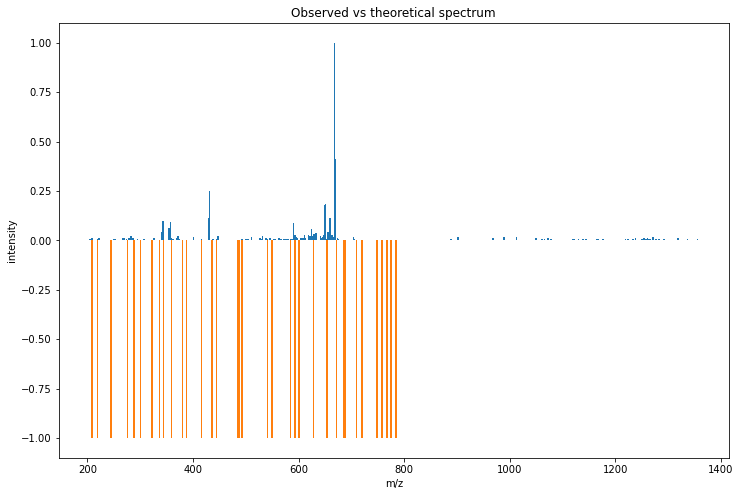

In [39]:
import numpy as np
from matplotlib import pyplot as plt

def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
  
    for element in obs_int:
         max(obs_int)
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

obs_mz, obs_int = observed_spectrum.get_peaks()

# The mass-to-charge of our observed spectrum ranges from 205 - 1400 m/z
print(min(obs_mz)) # 205.2110137939453
print(max(obs_mz)) # 1354.96240234375

# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

## Now we want to find matching peaks between observed and theoretical spectrum. 

In [40]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()

# use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)

# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

## The alignment contains a list of matched peak indices. We can simply inspect matching peaks with: 

In [41]:
# Print matching ions and mz from theoretical spectrum
print("Number of matched peaks: " + str(len(alignment)))
print("ion\ttheo. m/z\tobserved m/z")

for theo_idx, obs_idx in alignment:
    ion_name = theo_spectrum.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spectrum.getIntegerDataArrays()[0][theo_idx]
    print(ion_name + "\t" + str(ion_charge) + "\t"
      + str(theo_spectrum[theo_idx].getMZ())
      + "\t" + str(observed_spectrum[obs_idx].getMZ()))

Number of matched peaks: 9
ion	theo. m/z	observed m/z
b5++	2	208.601747294321	208.12258911132812
b4+	1	359.174754026171	359.0831604003906
b5+	1	416.19621812187097	416.0621032714844
y3+	1	437.21431135997096	437.6441650390625
y8++	2	492.76671106732095	492.26727294921875
y10++	2	592.824757822521	593.0861206054688
y11++	2	628.3433149022709	628.8251342773438
y13++	2	720.403904157471	720.127685546875
b11+	1	968.5233685254709	968.2996826171875


## The mirror plot can also be used to visualize the aligned spectrum:

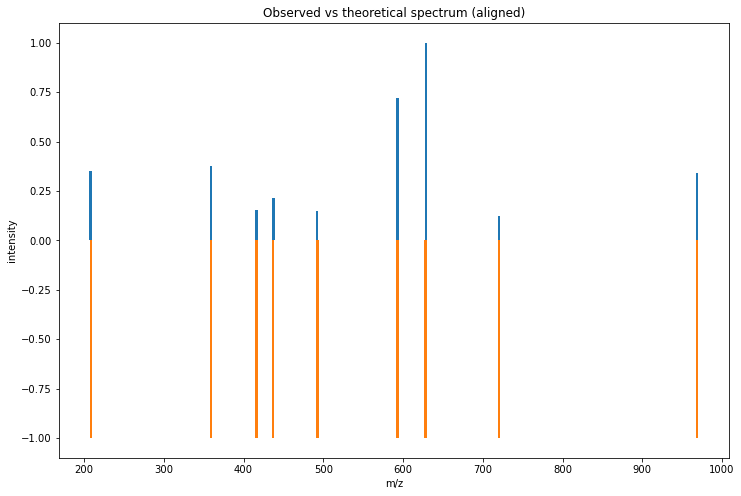

In [42]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)